In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy import optimize
import numpy as np
from astropy import units as u
from astropy import constants as const
from data import vla_data, t_peak_mjd, photometry_data, bran_disc, t_neutrino
from flux_utils import convert_radio
from plots import fontsize, fig_width

In [2]:
def find_photon_index(x, y, yerr):
    y_rad = np.array(y)
    yerr_rad = np.array(yerr) 
    x_rad = np.array(x)
    
    grad_guess = (np.log(max(y)) - np.log(min(y)))/(np.log(max(x)) - np.log(min(x)))

    def g(x, a, b):

        exp = a * np.exp(b * np.log(x))

        return exp

    popt, pcov = optimize.curve_fit(
        g,
        x_rad,
        y_rad,
        sigma=yerr_rad,
        p0=[y_rad[0], grad_guess],
        absolute_sigma=True,
    )
    
    def residuals(exp):
        diff = (exp - y)
        return np.sum((diff/yerr)**2.)
    
#     res = optimize.minimize(min_g, x0=(y_rad[0], grad_guess), method="L-BFGS-B")
#     print(res)
    
    perr = np.sqrt(np.diag(pcov))

    def fit_g(x, sd=0.):

        sig = perr[1]

        m = popt[1] + sd*sig

        def h(x, a):

            exp = a * np.exp(m * np.log(x))

            return exp

        popt_2, _ = optimize.curve_fit(h, x_rad, y_rad, sigma=yerr_rad,  p0=[y_rad[0]], absolute_sigma=True)

        exp = popt_2 * np.exp(m * np.log(x))

        return exp
    
    min_sq = residuals(fit_g(x_rad))
    f = 1.0
    while (residuals(fit_g(x_rad, f)) - min_sq) < 1.0:
        f*= 1.3
        
    perr[1] *= f
    
    plt.figure()
    plt.errorbar(x_rad, y_rad, yerr=yerr_rad, marker="o", linestyle=" ")
    plt.plot(x_rad, fit_g(x_rad), color="k", linestyle=":")
    plt.fill_between(x_rad, fit_g(x_rad, 1), fit_g(x_rad, -1), alpha=0.1, color="k")
    plt.fill_between(x_rad, fit_g(x_rad, 2), fit_g(x_rad, -2), alpha=0.1, color="k")

    plt.yscale("log")
    plt.xscale("log")

    print(f"Gradient = {popt[1]:.2f} +/- {perr[1]:.2f}")
    print(f"Photon Index = {-2.+popt[1]:.2f} +/- {perr[1]:.2f}")
    return 2. - popt[1], perr[1]

<ipython-input-3-2f1da16d883e>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = vla_data[mask]


Gradient = 0.17 +/- 0.05
Photon Index = -1.83 +/- 0.05


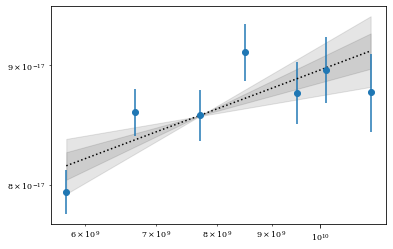

In [3]:
radio_times = vla_data.sort_values("mjd")["mjd"] - t_peak_mjd.mjd
tnt = 157.12999999999738
mask = radio_times == tnt
data = vla_data[mask]
convert_y = convert_radio(data["flux"], data["frequency"])
convert_y_err = convert_radio(data["flux_err"], data["frequency"])
f_mask = data["frequency"] > 5.
f_data = data[f_mask]
convert_y = list(convert_y[f_mask])
convert_y_err = list(convert_y_err[f_mask])
above_t = list(f_data["mjd"])[0]
above_p, above_err = find_photon_index(np.array(list(f_data["frequency"]))*10.**9, convert_y, convert_y_err)

In [4]:
bands = {
    "U": 3465 * u.angstrom,
    "UVW1": 2600 * u.angstrom,
    "UVM2": 2246 * u.angstrom,
    "UVW2": 1928 * u.angstrom,
    "g.ZTF": 464 * u.nm,
    "r.ZTF": 658 * u.nm,
    "r.SEDm": 658 * u.nm,
}

colors = {
    "r.IOO": "r",
    "r.ZTF": "r",
    "r.SEDM": "r",
    "g.ZTF": "g",
    "g.IOO": "g",
    "UVW2": "violet",
    "UVM2": "purple",
    "UVW1": "darkblue",
    "U": "blue",
    
}

Gradient = 1.10 +/- 0.72
Photon Index = -0.90 +/- 0.72
Gradient = 2.26 +/- 0.36
Photon Index = 0.26 +/- 0.36
Gradient = 2.35 +/- 0.28
Photon Index = 0.35 +/- 0.28
Gradient = 2.12 +/- 0.17
Photon Index = 0.12 +/- 0.17
Gradient = 1.92 +/- 0.40
Photon Index = -0.08 +/- 0.40
Gradient = 2.22 +/- 0.17
Photon Index = 0.22 +/- 0.17


<ipython-input-5-6f608e66e689>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-2-24c0e39c91d6>:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Gradient = 2.12 +/- 0.17
Photon Index = 0.12 +/- 0.17
Gradient = 2.18 +/- 0.16
Photon Index = 0.18 +/- 0.16
Gradient = 2.04 +/- 0.18
Photon Index = 0.04 +/- 0.18
Gradient = 2.14 +/- 0.23
Photon Index = 0.14 +/- 0.23
Gradient = 0.71 +/- 0.72
Photon Index = -1.29 +/- 0.72
Gradient = 2.17 +/- 0.18
Photon Index = 0.17 +/- 0.18
Gradient = 0.61 +/- 0.72
Photon Index = -1.39 +/- 0.72
Gradient = 2.44 +/- 0.19
Photon Index = 0.44 +/- 0.19
Gradient = 2.46 +/- 0.53
Photon Index = 0.46 +/- 0.53
Gradient = 2.30 +/- 0.24
Photon Index = 0.30 +/- 0.24
Gradient = 2.19 +/- 0.25
Photon Index = 0.19 +/- 0.25
Gradient = 1.96 +/- 0.84
Photon Index = -0.04 +/- 0.84
Gradient = 2.26 +/- 0.83
Photon Index = 0.26 +/- 0.83
Gradient = 2.20 +/- 0.38
Photon Index = 0.20 +/- 0.38
Gradient = 1.92 +/- 0.32
Photon Index = -0.08 +/- 0.32
Gradient = 2.17 +/- 0.71
Photon Index = 0.17 +/- 0.71


/usr/local/anaconda3/envs/bran_stark_paper/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Gradient = 1.21 +/- 1.39
Photon Index = -0.79 +/- 1.39
Gradient = 1.72 +/- 0.81
Photon Index = -0.28 +/- 0.81
Gradient = 1.71 +/- 0.87
Photon Index = -0.29 +/- 0.87
Gradient = 2.96 +/- 1.66
Photon Index = 0.96 +/- 1.66
Gradient = 1.48 +/- 1.82
Photon Index = -0.52 +/- 1.82
Failed


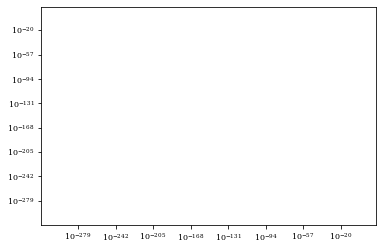

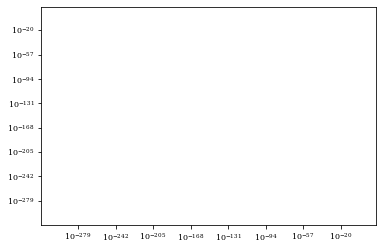

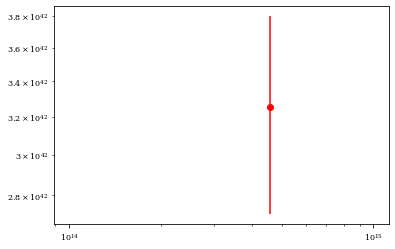

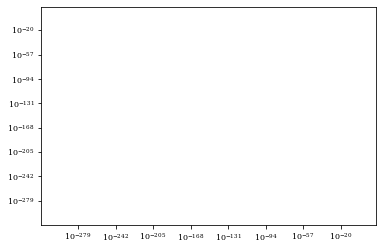

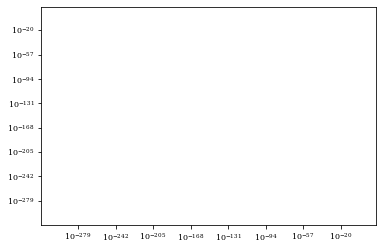

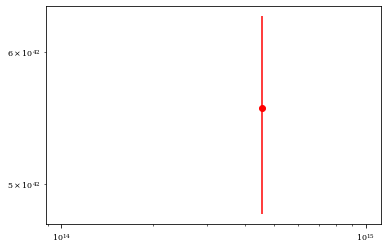

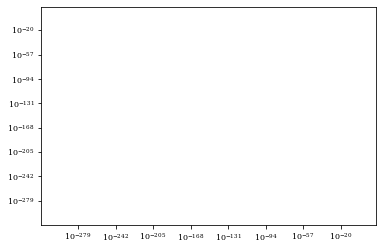

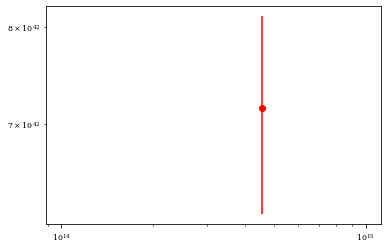

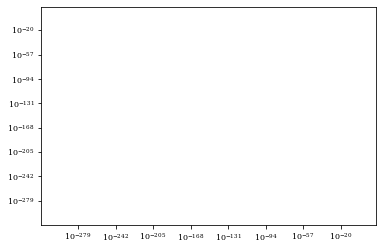

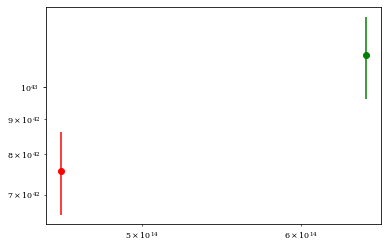

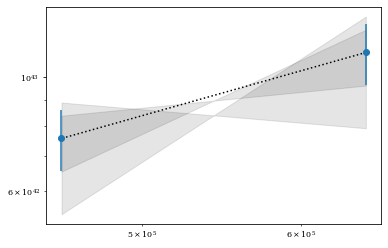

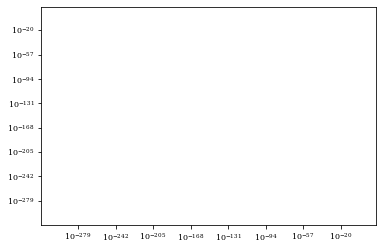

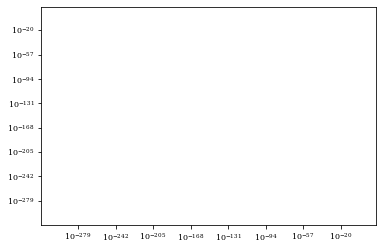

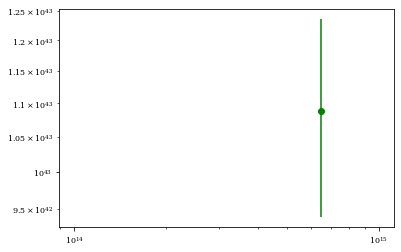

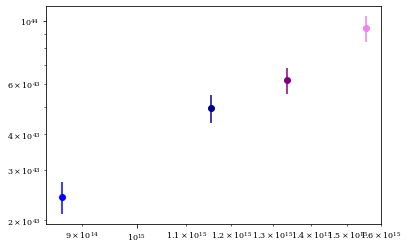

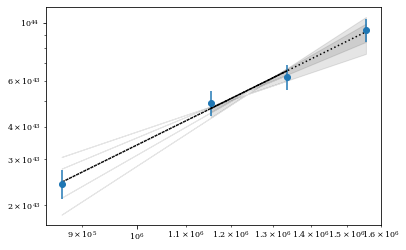

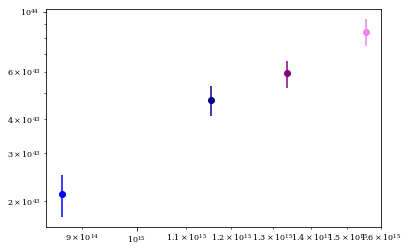

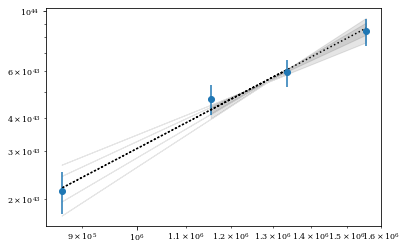

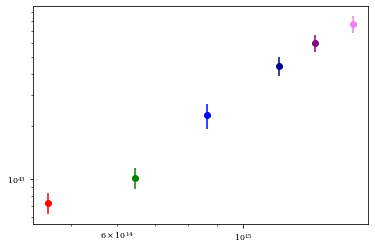

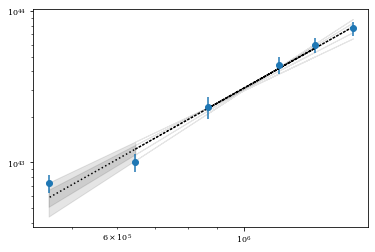

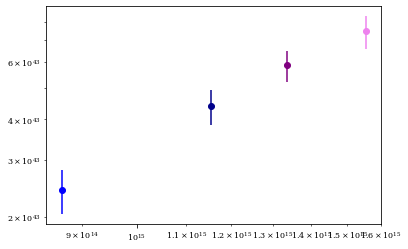

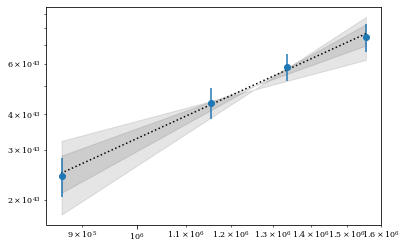

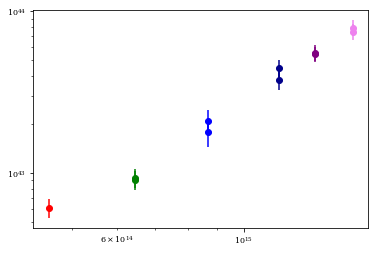

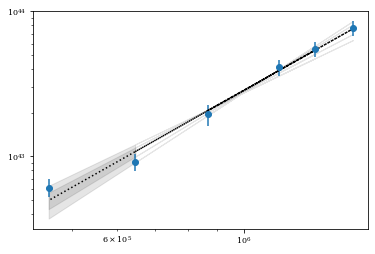

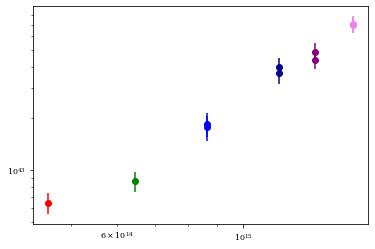

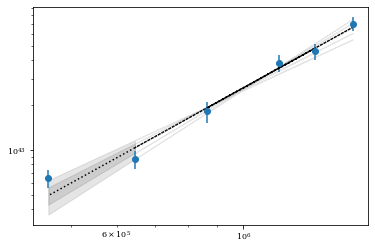

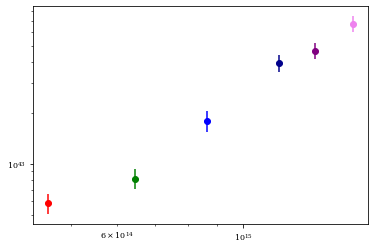

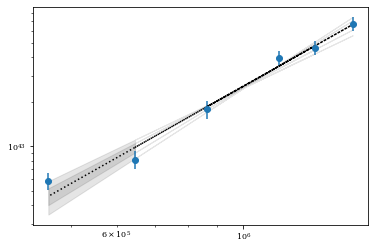

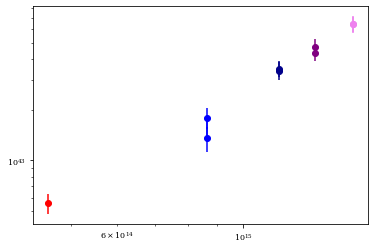

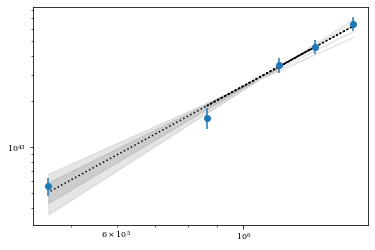

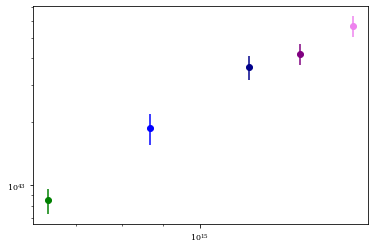

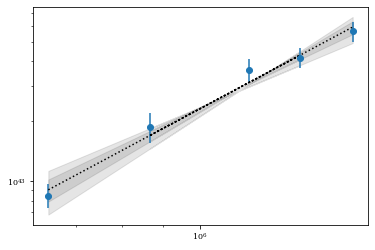

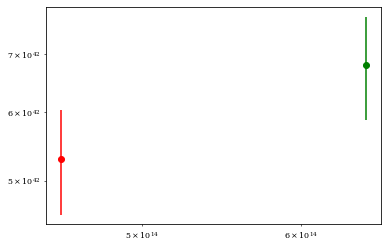

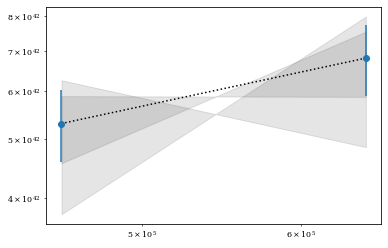

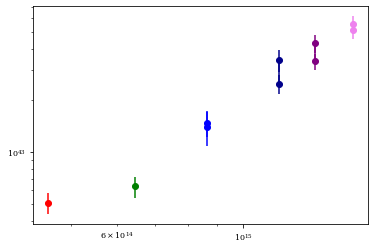

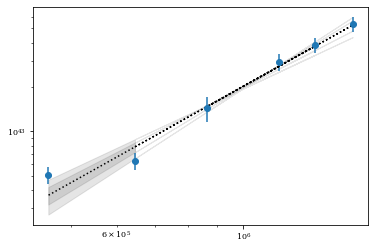

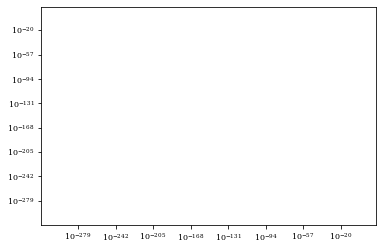

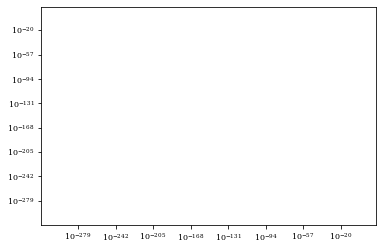

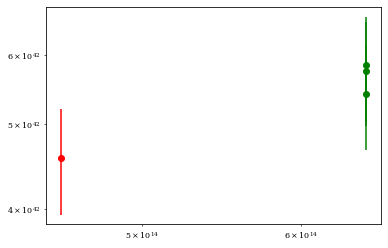

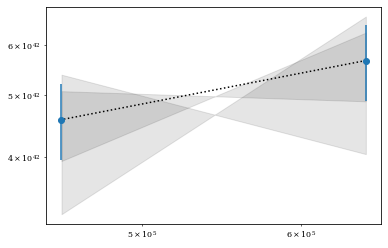

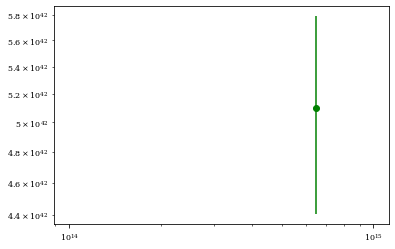

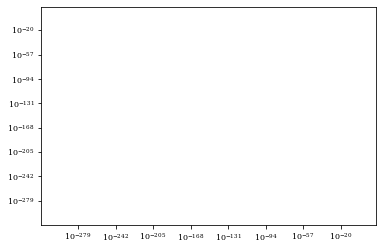

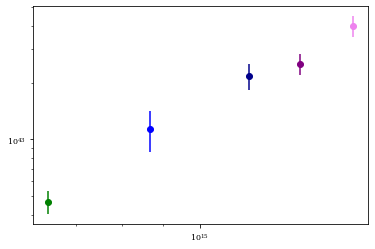

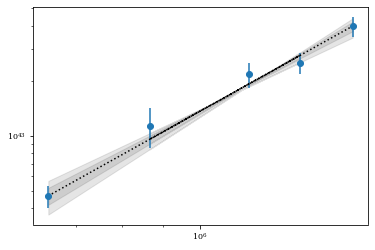

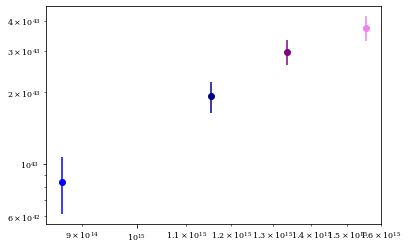

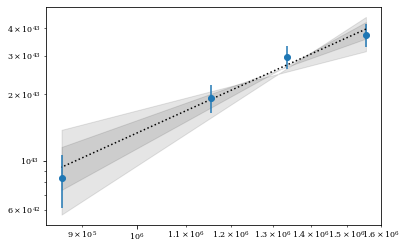

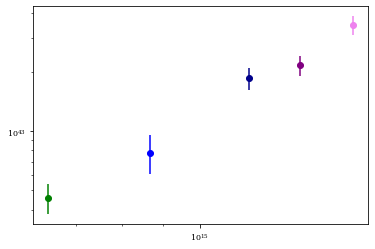

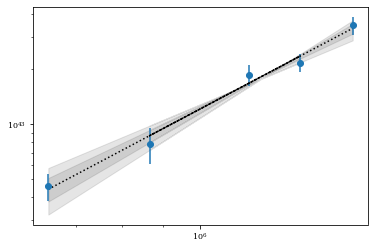

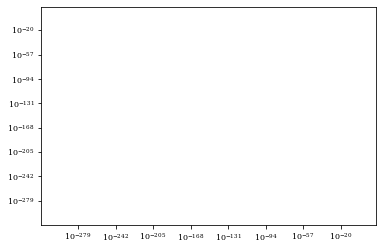

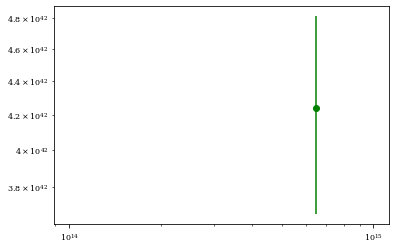

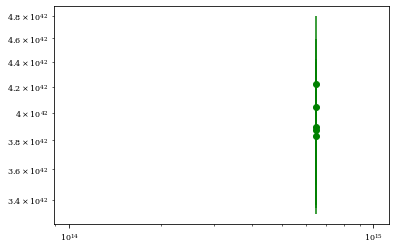

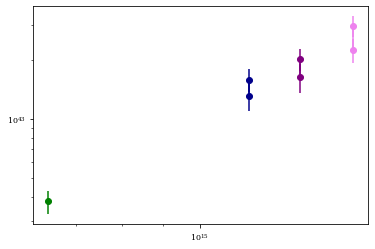

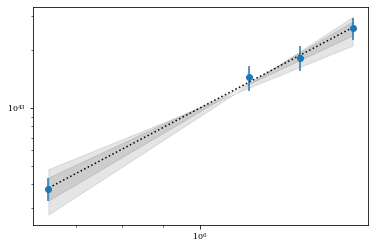

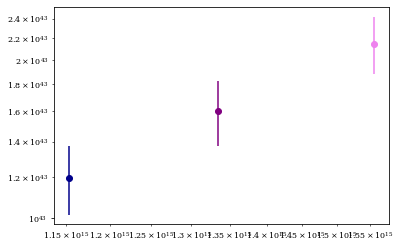

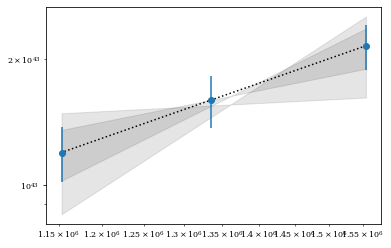

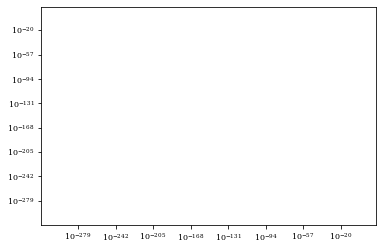

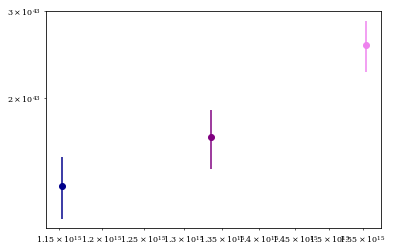

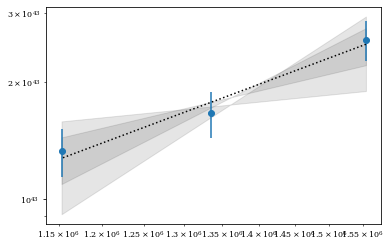

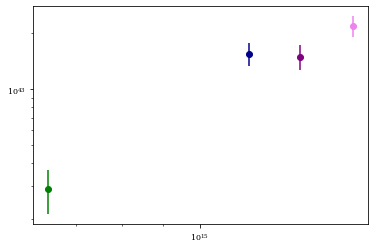

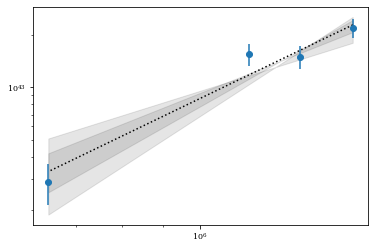

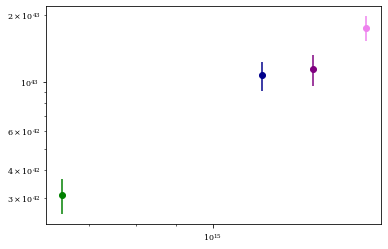

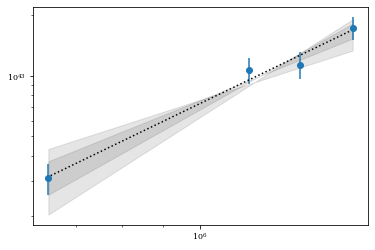

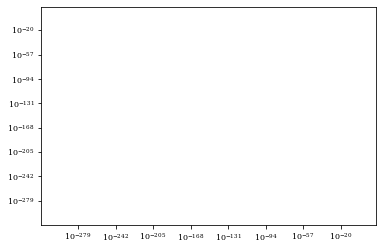

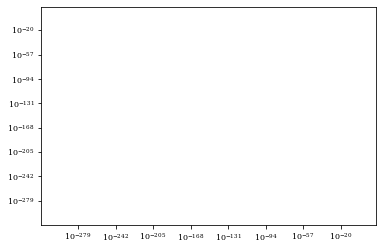

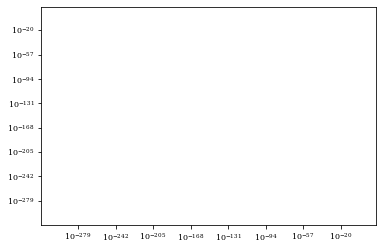

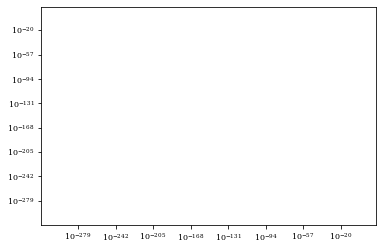

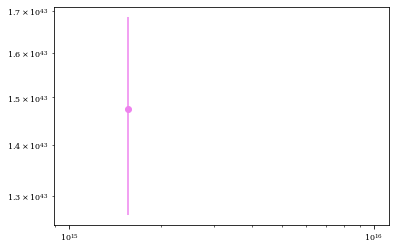

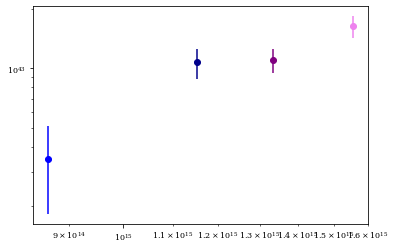

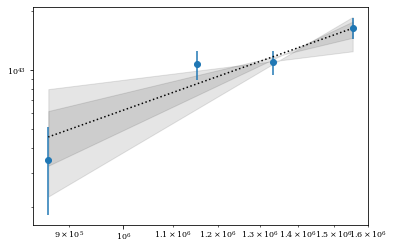

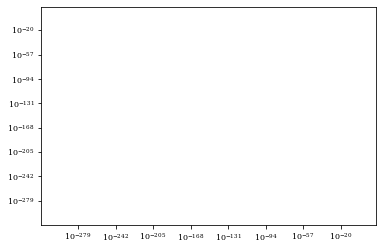

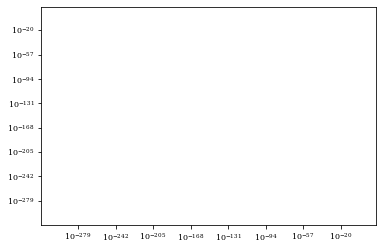

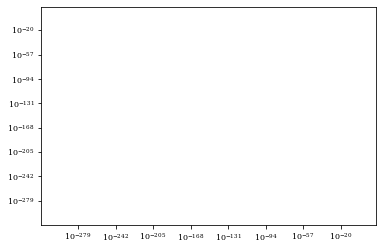

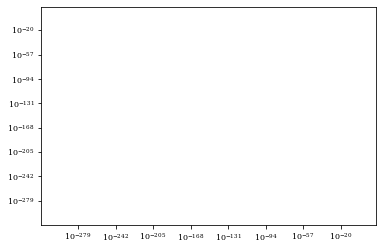

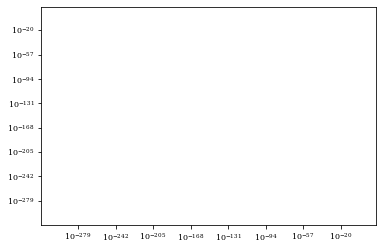

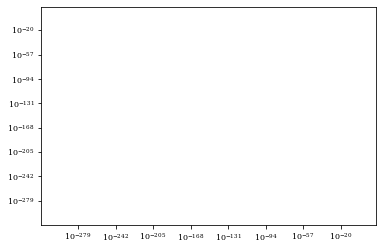

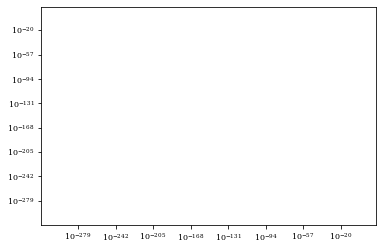

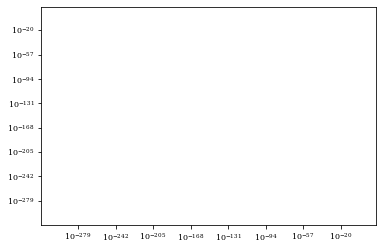

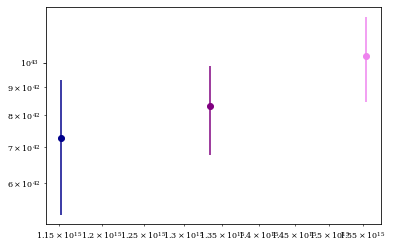

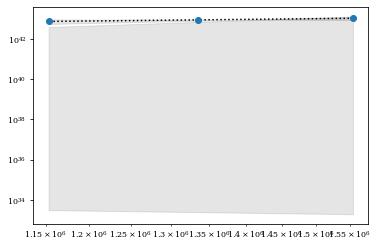

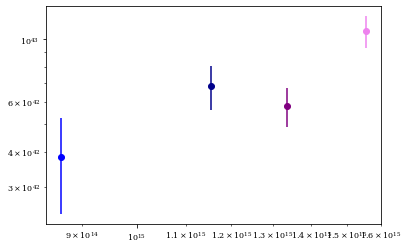

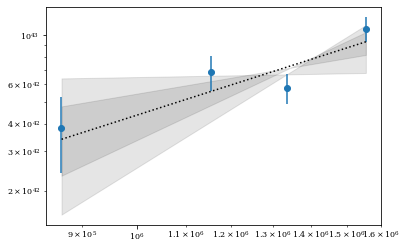

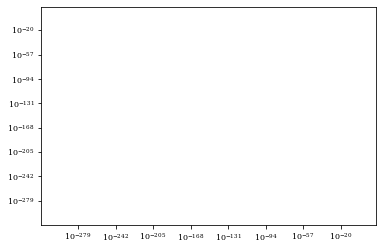

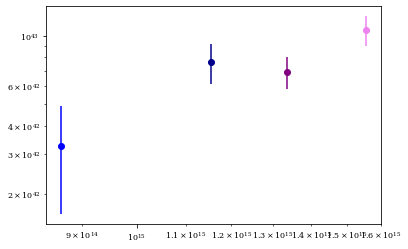

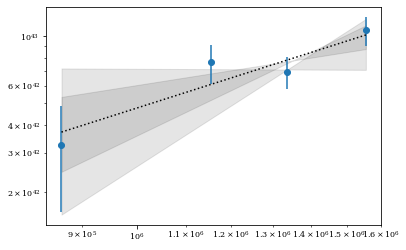

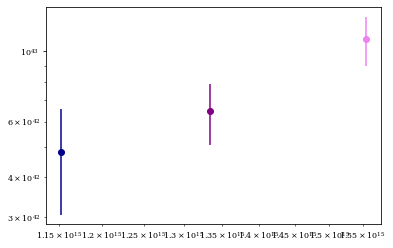

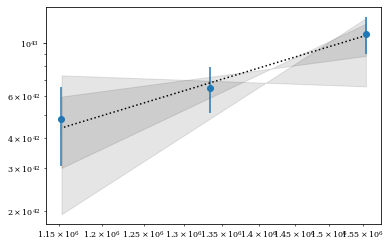

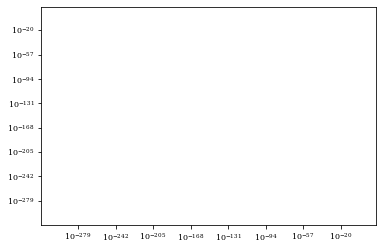

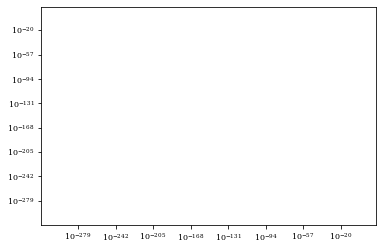

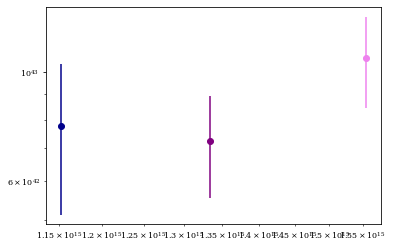

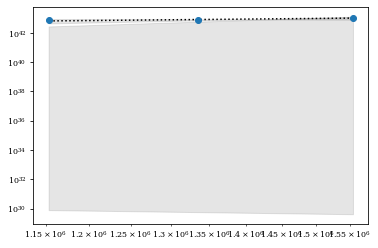

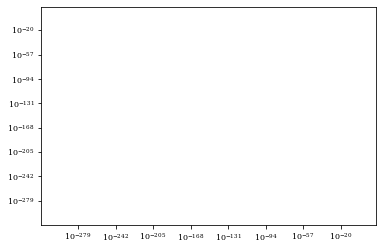

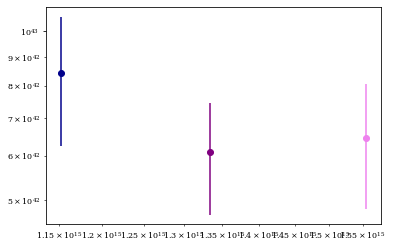

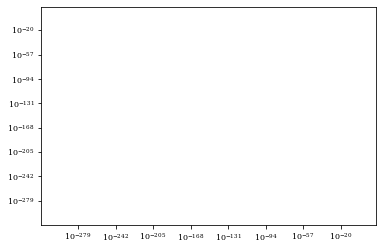

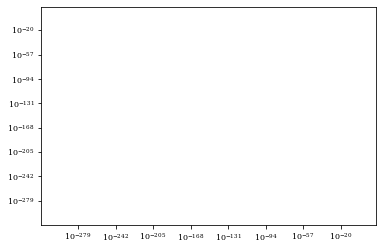

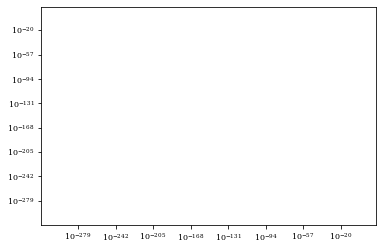

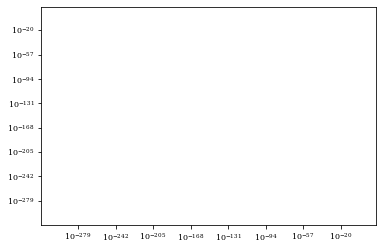

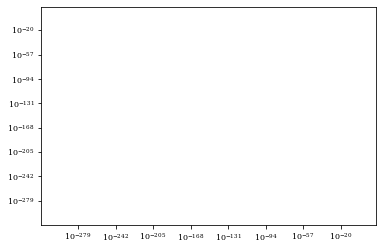

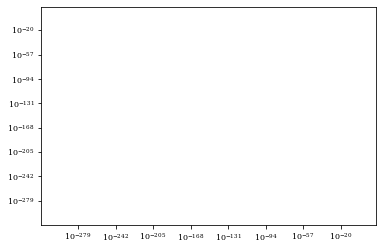

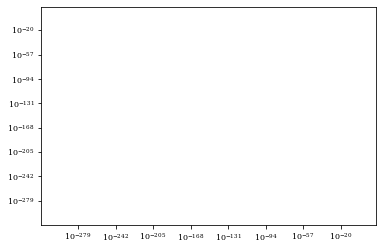

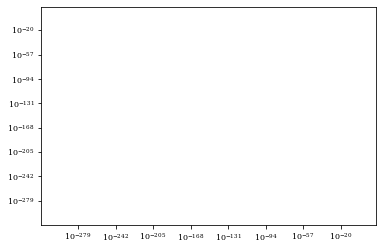

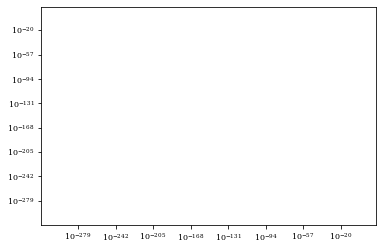

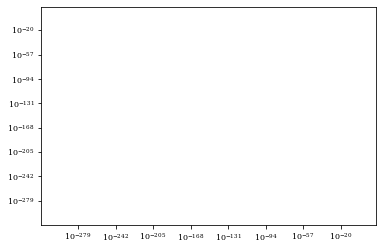

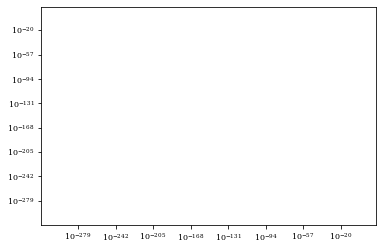

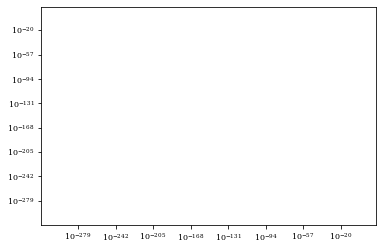

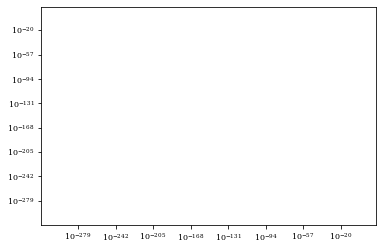

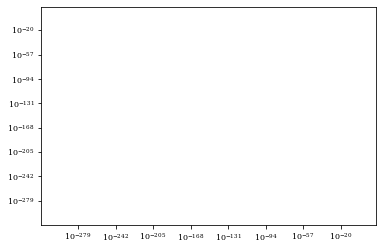

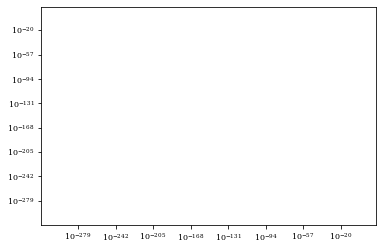

In [5]:
cmap = "plasma"
bins = np.linspace(min(photometry_data["#day_since_peak"]), max(photometry_data["#day_since_peak"]) + 50., 81)

index_times = []
photon_index = []
errs = []

ls_times = []
ls_index = []
ls_errs = []

for j, lower in enumerate(bins[:-1]):
    plt.figure()
    ax = plt.subplot(111)
    time_scale = bins[-1] - bins[0] 
    lower = bins[j]
    upper = bins[j + 1]
    mask = np.logical_and(
            photometry_data["#day_since_peak"] > lower,
            photometry_data["#day_since_peak"] < upper,
        )
                
    data = photometry_data[mask]
    
    fs = []
    lums = []
    yerrs = []

    for band in list(set(data["band"][mask])):
        if band in bands:
            wl = bands[band].to("m")
            f = (const.c / wl).to("Hz")
            
            bmask = np.logical_and(
                data["band"] == band,
                data["lum"] > 0.
            )

            bd = data[bmask]["lum"]
            err = np.sqrt(data[bmask]["err_lum"]**2. + (0.1*data[bmask]["lum"])**2.)
#             bd = np.array(list(bd[bd > 0]))
                
            x = np.ones_like(bd) * f.value
            if len(bd) > 0:
                ax.errorbar(
                    x,
                    bd,
                    yerr=err,
                    marker="o",
                    c=colors[band]
#                     c=data[bmask]["#day_since_peak"],
#                     vmin=bins[0],
#                     vmax=bins[-1],
#                     cmap=cmap
                ) 
                fs.append(f.value)
                lums.append(np.mean(bd))
                yerrs.append(np.mean(err))
                
    plt.yscale("log")
    plt.xscale("log")
   
    
    if len(fs) > 1:
        
        min_x = min(fs)
        max_x = max(fs)
        
        grad = (np.log(max(lums)) - np.log(min(lums)))/(np.log(max(fs)) - np.log(min(fs)))
                
        def f(x):
            return np.exp(np.log(min(lums)) + grad * (np.log(x) - np.log(min(fs))))
        
        x = [min_x, max_x]

#         plt.plot(
#             x,
#             f(x),
#             linestyle=":", 
#             c=matplotlib.cm.get_cmap(cmap)((np.mean([lower, upper]) - bins[0])/time_scale)
#         )
        
        try:
        
            grad, err = find_photon_index(np.array(fs)/10.**9, lums, yerrs)
            
            if len(fs) > 3:

                index_times.append(np.mean([lower, upper]))
                photon_index.append(grad)
                errs.append(err)
            else:
                ls_times.append(np.mean([lower, upper]))
                ls_index.append(grad)
                ls_errs.append(err)
            
        except RuntimeError:
            print("Failed")
            pass
        

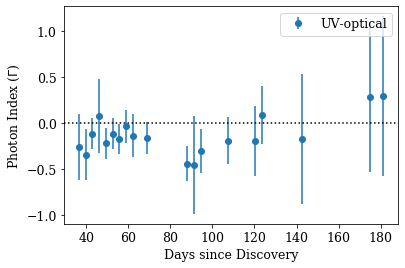

In [6]:
t_offset = bran_disc.mjd - t_peak_mjd.mjd

plt.figure(figsize=(fig_width, fig_width *2./3.))
ax = plt.subplot(111)
plt.errorbar(index_times - t_offset, np.array(photon_index), yerr=errs, marker="o", fmt=" ", label="UV-optical")
# plt.errorbar(ls_times - t_offset, ls_index, yerr=ls_errs, marker="o", fmt=" ")
plt.axhline(0.0, linestyle=":", color="k")
plt.legend(fontsize=fontsize)
plt.ylabel(r"Photon Index ($\Gamma$)", fontsize=fontsize)
plt.xlabel("Days since Discovery", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
plt.savefig("plots/photon_index.pdf")

Gradient = 2.94 +/- 0.83
Photon Index = 0.94 +/- 0.83
Gradient = 2.51 +/- 0.14
Photon Index = 0.51 +/- 0.14
Gradient = 2.17 +/- 0.09
Photon Index = 0.17 +/- 0.09
Gradient = 2.55 +/- 0.20
Photon Index = 0.55 +/- 0.20


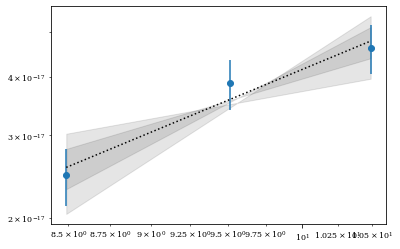

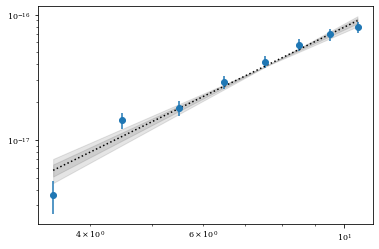

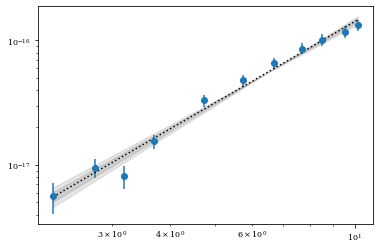

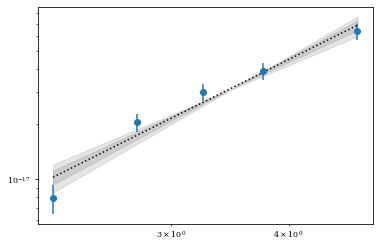

In [7]:
r_indexes = []
r_times = []
r_errors = []

for date_mjd in sorted(list(set(vla_data["mjd"]))):
    data = vla_data[vla_data["mjd"] == date_mjd]
    
    peak = data["flux"].idxmax(axis=1)
    data = data.loc[:peak]
    if len(data) > 3:
        data = data[:-1]
    convert_y = convert_radio(data["flux"], data["frequency"])
    convert_y_err = np.sqrt(convert_radio(data["flux_err"], data["frequency"])**2. + (0.1*convert_y)**2.)
    grad, err = find_photon_index(np.array(list(data["frequency"])), convert_y, convert_y_err)
    
    r_indexes.append(grad)
    r_errors.append(err)
    r_times.append(date_mjd)
    


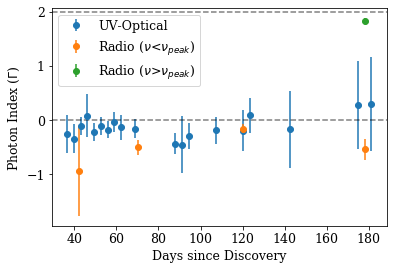

In [12]:
plt.figure(figsize=(fig_width, fig_width *2./3.))
ax = plt.subplot(111)
plt.errorbar(index_times - t_offset, np.array(photon_index), yerr=errs, marker="o", fmt=" ", label="UV-Optical")
# plt.errorbar(ls_times - t_offset, ls_index, yerr=ls_errs, marker="o", fmt=" ", label="UV-Optical (n_points <4)")
plt.errorbar(r_times - bran_disc.mjd, r_indexes, yerr=r_errors, marker="o", fmt=" ", label=r"Radio ($\nu \less \nu_{peak}$)")
plt.errorbar(above_t - bran_disc.mjd, above_p, yerr=above_err, marker="o", fmt=" ", label=r"Radio ($\nu \greater \nu_{peak}$)")
plt.axhline(0.0, linestyle="--", color="k", alpha=0.5)
plt.axhline(2.0, linestyle="--", color="k", alpha=0.5)
# plt.axvline(t_neutrino.mjd - bran_disc.mjd, linestyle=":", color="k", label="IC191001A")
# plt.ylim(-2.5, 2.5)
plt.legend(fontsize=fontsize)
plt.ylabel(r"Photon Index ($\Gamma$)", fontsize=fontsize)
plt.xlabel("Days since Discovery", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
plt.savefig("plots/photon_index.pdf")